Copyright 2022 Google LLC. SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Code as Policies Tabletop Manipulation Interactive Demo

This notebook is a part of the open-source code release associated with the paper:

[Code as Policies: Language Model Programs for Embodied Control](https://code-as-policies.github.io/)

This notebook gives an interactive demo for the simulated tabletop manipulation domain, where users can type in free-form instructions for the robot to execute, as seen in the paper section IV.D

**Instructions:** 

1) Obtain an OpenAI API Key in the link below and set it in the next cell:
https://openai.com/blog/openai-api/

2) Gain Codex access by joining the waitlist here:
https://openai.com/blog/openai-codex/

Once you have Codex access you can use `code-davinci-002` as the `model_name`. Using the GPT-3 model (`text-dainvci-002`) is also ok, but performance won't be as good (there will be more code logic errors).

3) Run all cells and input commands under "Interactive Demo" at the bottom.

In [40]:
openai_api_key = 'sk-KpMgNgTSYjOIgZH04aC062957dD747D88f147d9f986aC260'
model_name = 'gpt-4' # 'text-davinci-002'
base_url = "https://one-api.glm.ai/v1"

# Setup

In [41]:
# !pip install numpy scipy shapely astunparse pygments openai > /dev/null 2>&1 -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install imageio==2.4.1 imageio-ffmpeg pybullet moviepy -i https://pypi.tuna.tsinghua.edu.cn/simple

import os
import pybullet
import pybullet_data
import numpy as np
import threading
import copy
import openai
from openai import OpenAI
import cv2
# from google.colab.patches import cv2_imshow
from moviepy.editor import ImageSequenceClip

# imports for LMPs
import shapely
import ast
import astunparse
from time import sleep
from shapely.geometry import *
from shapely.affinity import *
from openai import RateLimitError, APIConnectionError
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import TerminalFormatter

model_name = 'gpt-4'
base_url = "https://one-api.glm.ai/v1"

client = OpenAI(api_key='sk-KpMgNgTSYjOIgZH04aC062957dD747D88f147d9f986aC260' , base_url="https://one-api.glm.ai/v1")
# client = OpenAI(api_key='' , base_url="https://api.deepseek.com/v1")


In [42]:


# user_input = 'while the left most block is the red block, move it toward the right.' #@param {allow-input: true, type:"string"}
# user_input = 'Move the yellow bottle 5cm to the right for 5 times'
# user_input= 'put the pink block to the red block, and put the purple block to the red block, and put the brown block to the red block'
# user_input = 'move the green bottle to the low edge'
# user_input = "I am at the top edge. Give me a bottle."
user_input = "I am so stupid to use you."

In [43]:
class LMP:

    def __init__(self, name, cfg, lmp_fgen, fixed_vars, variable_vars):
        self._name = name
        self._cfg = cfg

        self._base_prompt = self._cfg['prompt_text']

        self._stop_tokens = list(self._cfg['stop'])

        self._lmp_fgen = lmp_fgen

        self._fixed_vars = fixed_vars
        self._variable_vars = variable_vars
        self.exec_hist = ''

    def clear_exec_hist(self):
        self.exec_hist = ''

    def build_prompt(self, query, context=''):
        if len(self._variable_vars) > 0:
            variable_vars_imports_str = f"from utils import {', '.join(self._variable_vars.keys())}"
        else:
            variable_vars_imports_str = ''
        prompt = self._base_prompt.replace('{variable_vars_imports}', variable_vars_imports_str)

        if self._cfg['maintain_session']:
            prompt += f'\n{self.exec_hist}'

        if context != '':
            prompt += f'\n{context}'

        use_query = f'{self._cfg["query_prefix"]}{query}{self._cfg["query_suffix"]}'
        prompt += f'\n{use_query}'

        return prompt, use_query

    def __call__(self, query, context='', **kwargs):
        prompt, use_query = self.build_prompt(query, context=context)
        # print(f'Prompt for {self._name}:\n\n{prompt}\n')

        while True:
            try:
                code_str = client.chat.completions.create(
                    messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self._cfg['engine'],
                    # prompt=prompt,
                    # stop=self._stop_tokens,
                    # temperature=self._cfg['temperature'],
                    # engine=self._cfg['engine'],
                    # max_tokens=self._cfg['max_tokens']
                ).choices[0].message.content
                # print(f'Code for {self._name}:\n\n{code_str}\n')
                code_str = code_str.replace('```python', '').replace('```', '')
                break
            except (RateLimitError, APIConnectionError) as e:
                print(f'OpenAI API got err {e}')
                print('Retrying after 10s.')
                sleep(10)

        if self._cfg['include_context'] and context != '':
            to_exec = f'{context}\n{code_str}'
            to_log = f'{context}\n{use_query}\n{code_str}'
        else:
            to_exec = code_str
            to_log = f'{use_query}\n{to_exec}'

        to_log_pretty = highlight(to_log, PythonLexer(), TerminalFormatter())
        print(f'LMP {self._name} exec:\n\n{to_log_pretty}\n')

        new_fs = self._lmp_fgen.create_new_fs_from_code(code_str)
        self._variable_vars.update(new_fs)

        gvars = merge_dicts([self._fixed_vars, self._variable_vars])
        lvars = kwargs
        
        if not self._cfg['debug_mode']:
            exec_safe(to_exec, use_query, gvars, lvars)

        self.exec_hist += f'\n{to_exec}'

        if self._cfg['maintain_session']:
            self._variable_vars.update(lvars)

        if self._cfg['has_return']:
            return lvars[self._cfg['return_val_name']]


class LMPFGen:

    def __init__(self, cfg, fixed_vars, variable_vars):
        self._cfg = cfg

        self._stop_tokens = list(self._cfg['stop'])
        self._fixed_vars = fixed_vars
        self._variable_vars = variable_vars

        self._base_prompt = self._cfg['prompt_text']

    def create_f_from_sig(self, f_name, f_sig, other_vars=None, fix_bugs=False, return_src=False):
        print(f'Creating function: {f_sig}')

        use_query = f'{self._cfg["query_prefix"]}{f_sig}{self._cfg["query_suffix"]}'
        prompt = f'{self._base_prompt}\n{use_query}'

        print(f'Prompt for LMP FGEN:\n\n{prompt}\n')

        while True:
            try:
                f_src = client.chat.completions.create(
                    messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=self._cfg['engine'],
                    # prompt=prompt,
                    # stop=self._stop_tokens,
                    # temperature=self._cfg['temperature'],
                    # engine=self._cfg['engine'],
                    # max_tokens=self._cfg['max_tokens']
                ).choices[0].message.content
                print(f'Code for LMP FGEN:\n\n{f_src}\n')
                break
            except (RateLimitError, APIConnectionError) as e:
                print(f'OpenAI API got err {e}')
                print('Retrying after 10s.')
                sleep(10)

        if fix_bugs:
            f_src = client.chat.completions.create(
                model=self._cfg['engine'],
                messages=[
                    {
                        "role": "user",
                        "content": '# ' + f_src + 'Fix the bug if there is one. Improve readability. Keep same inputs and outputs. Only small changes. No comments.',
                    }
                ],
                # input='# ' + f_src,
                temperature=0,
                # instruction='Fix the bug if there is one. Improve readability. Keep same inputs and outputs. Only small changes. No comments.',
            ).choices[0].message.content

        if other_vars is None:
            other_vars = {}
        gvars = merge_dicts([self._fixed_vars, self._variable_vars, other_vars])
        lvars = {}
        
        exec_safe(f_src, use_query, gvars, lvars)

        f = lvars[f_name]

        to_print = highlight(f'{use_query}\n{f_src}', PythonLexer(), TerminalFormatter())
        print(f'LMP FGEN created:\n\n{to_print}\n')

        if return_src:
            return f, f_src
        return f

    def create_new_fs_from_code(self, code_str, other_vars=None, fix_bugs=False, return_src=False):
        fs, f_assigns = {}, {}
        f_parser = FunctionParser(fs, f_assigns)
        f_parser.visit(ast.parse(code_str))
        for f_name, f_assign in f_assigns.items():
            if f_name in fs:
                fs[f_name] = f_assign

        if other_vars is None:
            other_vars = {}

        new_fs = {}
        srcs = {}
        for f_name, f_sig in fs.items():
            all_vars = merge_dicts([self._fixed_vars, self._variable_vars, new_fs, other_vars])
            if not var_exists(f_name, all_vars):
                f, f_src = self.create_f_from_sig(f_name, f_sig, new_fs, fix_bugs=fix_bugs, return_src=True)

                # recursively define child_fs in the function body if needed
                f_def_body = astunparse.unparse(ast.parse(f_src).body[0].body)
                child_fs, child_f_srcs = self.create_new_fs_from_code(
                    f_def_body, other_vars=all_vars, fix_bugs=fix_bugs, return_src=True
                )

                if len(child_fs) > 0:
                    new_fs.update(child_fs)
                    srcs.update(child_f_srcs)

                    # redefine parent f so newly created child_fs are in scope
                    gvars = merge_dicts([self._fixed_vars, self._variable_vars, new_fs, other_vars])
                    lvars = {}
                    
                    exec_safe(f_src, gvars, lvars)
                    
                    f = lvars[f_name]

                new_fs[f_name], srcs[f_name] = f, f_src

        if return_src:
            return new_fs, srcs
        return new_fs


class FunctionParser(ast.NodeTransformer):

    def __init__(self, fs, f_assigns):
      super().__init__()
      self._fs = fs
      self._f_assigns = f_assigns

    def visit_Call(self, node):
        self.generic_visit(node)
        if isinstance(node.func, ast.Name):
            f_sig = astunparse.unparse(node).strip()
            f_name = astunparse.unparse(node.func).strip()
            self._fs[f_name] = f_sig
        return node

    def visit_Assign(self, node):
        self.generic_visit(node)
        if isinstance(node.value, ast.Call):
            assign_str = astunparse.unparse(node).strip()
            f_name = astunparse.unparse(node.value.func).strip()
            self._f_assigns[f_name] = assign_str
        return node


def var_exists(name, all_vars):
    try:
        eval(name, all_vars)
    except:
        exists = False
    else:
        exists = True
    return exists


def merge_dicts(dicts):
    return {
        k : v 
        for d in dicts
        for k, v in d.items()
    }
    
edit_prompt = '''
\n\n
{instrution}the code has some errors as follows, please re-write the code. Only response **python code**, don't say any other thing like "```python"!{\instruction}\n
'''

def exec_safe(code_str, use_query=None, gvars=None, lvars=None):
    banned_phrases = ['import', '__']
    for phrase in banned_phrases:
        assert phrase not in code_str
  
    if gvars is None:
        gvars = {}
    if lvars is None:
        lvars = {}
    empty_fn = lambda *args, **kwargs: None
    custom_gvars = merge_dicts([
        gvars,
        {'exec': empty_fn, 'eval': empty_fn}
    ])
    retry_times = 0
    max_retry_times = 6
    prompt = ""
    while True:
        try:
            exec(code_str, custom_gvars, lvars)
            break
        except Exception as e:
            print(f"get error {type(e)}: {e}, need retry to change code for time {retry_times}.")
            retry_times+=1
            if retry_times>max_retry_times:
                exit(0)
            prompt = edit_prompt+"{query}"+user_input+"{\query}\n"
            prompt += "{command}"+use_query+"{\command}\n"
            prompt += "{code}"+code_str+"{\code}"+"{error}"+str(e)+"{\error}\n\n"
            print("exec prompt:\n\n", prompt)
            while True:
                try:
                    code_str = client.chat.completions.create(
                            messages=[
                            {
                                "role": "user",
                                "content": prompt,
                            }
                        ],
                        model='gpt-4o-2024-05-13',
                        ).choices[0].message.content
                    print(f'Code for exec rewrite:\n\n{code_str}\n')
                    break
                except Exception as e:
                    print(f'OpenAI API got err {e}')
                    print('Retrying after 10s.')
                    sleep(10)

## **Table Top Sim Env**
Define PyBullet-based environment with a UR5e and 2-finger gripper

In [44]:
# # Global constants: pick and place objects, colors, workspace bounds
COLORS = {
    'blue':   (78/255,  121/255, 167/255, 255/255),
    'red':    (255/255,  87/255,  89/255, 255/255),
    'green':  (89/255,  169/255,  79/255, 255/255),
    'orange': (242/255, 142/255,  43/255, 255/255),
    'yellow': (237/255, 201/255,  72/255, 255/255),
    'purple': (176/255, 122/255, 161/255, 255/255),
    'pink':   (255/255, 157/255, 167/255, 255/255),
    'cyan':   (118/255, 183/255, 178/255, 255/255),
    'brown':  (156/255, 117/255,  95/255, 255/255),
    'gray':   (186/255, 176/255, 172/255, 255/255),
}

CORNER_POS = {
  'top left corner':     (-0.3 + 0.05, -0.2 - 0.05, 0),
  'top side':            (0,           -0.2 - 0.05, 0),
  'top right corner':    (0.3 - 0.05,  -0.2 - 0.05, 0),
  'left side':           (-0.3 + 0.05, -0.5,        0),
  'middle':              (0,           -0.5,        0),
  'right side':          (0.3 - 0.05,  -0.5,        0),
  'bottom left corner':  (-0.3 + 0.05, -0.8 + 0.05, 0),
  'bottom side':         (0,           -0.8 + 0.05, 0),
  'bottom right corner': (0.3 - 0.05,  -0.8 + 0.05, 0),
}

ALL_BLOCKS = ['blue block', 'red block', 'green block', 'orange block', 'yellow block', 'purple block', 'pink block', 'cyan block', 'brown block', 'gray block']
ALL_BOWLS = ['blue bowl', 'red bowl', 'green bowl', 'orange bowl', 'yellow bowl', 'purple bowl', 'pink bowl', 'cyan bowl', 'brown bowl', 'gray bowl']
ALL_BOTTLES = ['blue bottle', 'red bottle', 'green bottle', 'orange bottle', 'yellow bottle', 'purple bottle', 'pink bottle', 'cyan bottle', 'brown bottle', 'gray bottle']

PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[-0.3, 0.3], [-0.8, -0.2], [0, 0.15]])  # X Y Z

In [45]:
# Gripper (Robotiq 2F85) code

class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = 'robotiq_2f_85/robotiq_2f_85.urdf'
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool.
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  def check_grasp(self):
    while self.moving():
      sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist

  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

In [46]:
# Gym-style environment code
object_ids = {}
class PickPlaceEnv():

  def __init__(self, render=False, high_res=False, high_frame_rate=False):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

    self.render = render
    self.high_res = high_res
    self.high_frame_rate = high_frame_rate

  def reset(self, object_list):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Load objects according to config.
    self.object_list = object_list
    self.obj_name_to_id = {}
    obj_xyz = np.zeros((0, 3))
    for obj_name in object_list:
      if ('bottle' in obj_name) or ('bowl' in obj_name):

        # Get random position 15cm+ from other objects.
        timestap = 0
        while True:
          if timestap>15:
            break
          else: 
            timestap+=1
          rand_x = np.random.uniform(BOUNDS[0, 0] + 0.1, BOUNDS[0, 1] - 0.1)
          rand_y = np.random.uniform(BOUNDS[1, 0] + 0.1, BOUNDS[1, 1] - 0.1)
          rand_xyz = np.float32([rand_x, rand_y, 0.03]).reshape(1, 3)
          if len(obj_xyz) == 0:
            obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
            break
          else:
            nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
            if nn_dist > 0.15:
              obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
              break
        
        object_color = COLORS[obj_name.split(' ')[0]]
        object_type = obj_name.split(' ')[1]
        object_position = rand_xyz.squeeze()
        if object_type == 'bottle':
          object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
          object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
        elif object_type == 'bowl':
          object_position[2] = 0
          object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
        pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
        object_ids[obj_name] = object_id
        self.obj_name_to_id[obj_name] = object_id
    

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
      pybullet.stepSimulation()

    # record object positions at reset
    self.init_pos = {name: self.get_obj_pos(name) for name in object_list}

    return self.get_observation()

  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)
  
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)

  def get_ee_pos(self):
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    return ee_xyz

  def step(self, action=None):
    """Do pick and place motion primitive."""
    pick_pos, place_pos = action['pick'].copy(), action['place'].copy()
    # pick_pos = shapely.geometry.LineString(action['pick'].coords[:])
    # place_pos = shapely.geometry.LineString(action['place'].coords[:])

    # Set fixed primitive z-heights.
    hover_xyz = np.float32([pick_pos[0], pick_pos[1], 0.2])
    if pick_pos.shape[-1] == 2:
      pick_xyz = np.append(pick_pos, 0.025)
    else:
      pick_xyz = pick_pos
      pick_xyz[2] = 0.025
    if place_pos.shape[-1] == 2:
      place_xyz = np.append(place_pos, 0.15)
    else:
      place_xyz = place_pos
      place_xyz[2] = 0.15

    # Move to object.
    ee_xyz = self.get_ee_pos()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    while np.linalg.norm(pick_xyz - ee_xyz) > 0.01:
      self.movep(pick_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    # Pick up object.
    self.gripper.activate()
    for _ in range(240):
      self.step_sim_and_render()
    while np.linalg.norm(hover_xyz - ee_xyz) > 0.01:
      self.movep(hover_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()
    
    for _ in range(50):
      self.step_sim_and_render()
    
    # Move to place location.
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    # Place down object.
    while (not self.gripper.detect_contact()) and (place_xyz[2] > 0.03):
      place_xyz[2] -= 0.001
      self.movep(place_xyz)
      for _ in range(3):
        self.step_sim_and_render()
    self.gripper.release()
    for _ in range(240):
      self.step_sim_and_render()
    place_xyz[2] = 0.2
    ee_xyz = self.get_ee_pos()
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()
    place_xyz = np.float32([0, -0.5, 0.2])
    while np.linalg.norm(place_xyz - ee_xyz) > 0.01:
      self.movep(place_xyz)
      self.step_sim_and_render()
      ee_xyz = self.get_ee_pos()

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)      
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    interval = 40 if self.high_frame_rate else 60
    # Render current image at 8 FPS.
    if self.sim_step % interval == 0 and self.render:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    if not self.high_res:
      image_size = (240, 240)
      intrinsics = (120., 0, 120., 0, 120., 120., 0, 0, 1)
    else:
      image_size=(360, 360)
      intrinsics=(180., 0, 180., 0, 180., 180., 0, 0, 1)
    color, _, _, _, _ = env.render_image(image_size, intrinsics)
    return color

  def get_reward(self):
    return None

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap

    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -0.85, 0.4)
    orientation = (np.pi / 4 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=True

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            'constant', constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap
  
  def on_top_of(self, obj_a, obj_b):
    """
    check if obj_a is on top of obj_b
    condition 1: l2 distance on xy plane is less than a threshold
    condition 2: obj_a is higher than obj_b
    """
    obj_a_pos = self.get_obj_pos(obj_a)
    obj_b_pos = self.get_obj_pos(obj_b)
    xy_dist = np.linalg.norm(obj_a_pos[:2] - obj_b_pos[:2])
    if obj_b in CORNER_POS:
      is_near = xy_dist < 0.06
      return is_near
    elif 'bowl' in obj_b:
      is_near = xy_dist < 0.06
      is_higher = obj_a_pos[2] > obj_b_pos[2]
      return is_near and is_higher
    else:
      is_near = xy_dist < 0.04
      is_higher = obj_a_pos[2] > obj_b_pos[2]
      return is_near and is_higher
  
  def get_obj_id(self, obj_name):
    try:
      if obj_name in self.obj_name_to_id:
        obj_id = self.obj_name_to_id[obj_name]
      else:
        obj_name = obj_name.replace('circle', 'bowl').replace('square', 'bottle').replace('small', '').strip()
        obj_id = self.obj_name_to_id[obj_name]
    except:
      print(f'requested_name="{obj_name}"')
      print(f'available_objects_and_id="{self.obj_name_to_id}')
    return obj_id
  
  def get_obj_pos(self, obj_name):
    obj_name = obj_name.replace('the', '').replace('_', ' ').strip()
    if obj_name in CORNER_POS:
      position = np.float32(np.array(CORNER_POS[obj_name]))
    else:
      pick_id = self.get_obj_id(obj_name)
      pose = pybullet.getBasePositionAndOrientation(pick_id)
      position = np.float32(pose[0])
    return position
  
  def get_bounding_box(self, obj_name):
    obj_id = self.get_obj_id(obj_name)
    return pybullet.getAABB(obj_id)

## LMP Setup

### LMP Wrapper

In [47]:
class LMP_wrapper():

  def __init__(self, env, cfg, render=False):
    self.env = env
    self._cfg = cfg
    self.object_names = list(self._cfg['env']['init_objs'])
    
    self._min_xy = np.array(self._cfg['env']['coords']['bottom_left'])
    self._max_xy = np.array(self._cfg['env']['coords']['top_right'])
    self._range_xy = self._max_xy - self._min_xy

    self._table_z = self._cfg['env']['coords']['table_z']
    self.render = render

  def is_obj_visible(self, obj_name):
    return obj_name in self.object_names

  def get_obj_names(self):
    return self.object_names[::]

  def denormalize_xy(self, pos_normalized):
    return pos_normalized * self._range_xy + self._min_xy

  def get_corner_positions(self):
    unit_square = box(0, 0, 1, 1)
    normalized_corners = np.array(list(unit_square.exterior.coords))[:4]
    corners = np.array(([self.denormalize_xy(corner) for corner in normalized_corners]))
    return corners

  def get_side_positions(self):
    side_xs = np.array([0, 0.5, 0.5, 1])
    side_ys = np.array([0.5, 0, 1, 0.5])
    normalized_side_positions = np.c_[side_xs, side_ys]
    side_positions = np.array(([self.denormalize_xy(corner) for corner in normalized_side_positions]))
    return side_positions

  def get_obj_pos(self, obj_name):
    # return the xy position of the object in robot base frame
    return self.env.get_obj_pos(obj_name)[:2]

  def get_obj_position_np(self, obj_name):
    return self.get_pos(obj_name)

  def get_bbox(self, obj_name):
    # return the axis-aligned object bounding box in robot base frame (not in pixels)
    # the format is (min_x, min_y, max_x, max_y)
    bbox = self.env.get_bounding_box(obj_name)
    return bbox

  def get_color(self, obj_name):
    for color, rgb in COLORS.items():
      if color in obj_name:
        return rgb

  def pick_place(self, pick_pos, place_pos):
    pick_pos_xyz = np.r_[pick_pos, [self._table_z]]
    place_pos_xyz = np.r_[place_pos, [self._table_z]]
    pass

  def put_first_on_second(self, arg1, arg2):
    # put the object with obj_name on top of target
    # target can either be another object name, or it can be an x-y position in robot base frame
    pick_pos = self.get_obj_pos(arg1) if isinstance(arg1, str) else arg1
    print("pick_pos: ", pick_pos)
    place_pos = self.get_obj_pos(arg2) if isinstance(arg2, str) else arg2
    self.env.step(action={'pick': pick_pos, 'place': place_pos})

  def get_robot_pos(self):
    # return robot end-effector xy position in robot base frame
    return self.env.get_ee_pos()

  def goto_pos(self, position_xy):
    # move the robot end-effector to the desired xy position while maintaining same z
    ee_xyz = self.env.get_ee_pos()
    position_xyz = np.concatenate([position_xy, ee_xyz[-1]])
    while np.linalg.norm(position_xyz - ee_xyz) > 0.01:
      self.env.movep(position_xyz)
      self.env.step_sim_and_render()
      ee_xyz = self.env.get_ee_pos()

  def follow_traj(self, traj):
    for pos in traj:
      self.goto_pos(pos)

  def get_corner_positions(self):
    normalized_corners = np.array([
        [0, 1],
        [1, 1],
        [0, 0],
        [1, 0]
    ])
    return np.array(([self.denormalize_xy(corner) for corner in normalized_corners]))

  def get_side_positions(self):
    normalized_sides = np.array([
        [0.5, 1],
        [1, 0.5],
        [0.5, 0],
        [0, 0.5]
    ])
    return np.array(([self.denormalize_xy(side) for side in normalized_sides]))

  def get_corner_name(self, pos):
    corner_positions = self.get_corner_positions()
    corner_idx = np.argmin(np.linalg.norm(corner_positions - pos, axis=1))
    return ['top left corner', 'top right corner', 'bottom left corner', 'botom right corner'][corner_idx]

  def get_side_name(self, pos):
    side_positions = self.get_side_positions()
    side_idx = np.argmin(np.linalg.norm(side_positions - pos, axis=1))
    return ['top side', 'right side', 'bottom side', 'left side'][side_idx]

### LMP Prompts

In [48]:
prompt_tabletop_ui = '''
# Python 2D robot control script
import numpy as np
from env_utils import put_first_on_second, get_obj_pos, get_obj_names, say, get_corner_name, get_side_name, is_obj_visible, stack_objects_in_order
from plan_utils import parse_obj_name, parse_position, parse_question, transform_shape_pts

objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# the yellow block on the yellow bowl.
say('Ok - putting the yellow block on the yellow bowl')
put_first_on_second('yellow block', 'yellow bowl')
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# which block did you move.
say('I moved the yellow block')
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# move the green block to the top right corner.
say('Got it - putting the green block on the top right corner')
corner_pos = parse_position('top right corner')
put_first_on_second('green block', corner_pos)
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# stack the blue bowl on the yellow bowl on the green block.
order_bottom_to_top = ['green block', 'yellow block', 'blue bowl']
say(f'Sure - stacking from top to bottom: {", ".join(order_bottom_to_top)}')
stack_objects_in_order(object_names=order_bottom_to_top)
objects = ['cyan block', 'white block', 'cyan bowl', 'blue block', 'blue bowl', 'white bowl']
# move the cyan block into its corresponding bowl.
matches = {'cyan block': 'cyan bowl'}
say('Got it - placing the cyan block on the cyan bowl')
for first, second in matches.items():
  put_first_on_second(first, get_obj_pos(second))
objects = ['cyan block', 'white block', 'cyan bowl', 'blue block', 'blue bowl', 'white bowl']
# make a line of blocks on the right side.
say('No problem! Making a line of blocks on the right side')
block_names = parse_obj_name('the blocks', f'objects = {get_obj_names()}')
line_pts = parse_position(f'a 30cm vertical line on the right with {len(block_names)} points')
for block_name, pt in zip(block_names, line_pts):
  put_first_on_second(block_name, pt)
objects = ['yellow block', 'red block', 'yellow bowl', 'gray block', 'gray bowl', 'red bowl']
# put the small banana colored thing in between the blue bowl and green block.
say('Sure thing - putting the yellow block between the blue bowl and the green block')
target_pos = parse_position('a point in the middle betweeen the blue bowl and the green block')
put_first_on_second('yellow block', target_pos)
objects = ['yellow block', 'red block', 'yellow bowl', 'gray block', 'gray bowl', 'red bowl']
# can you cut the bowls in half.
say('no, I can only move objects around')
objects = ['yellow block', 'green block', 'yellow bowl', 'gray block', 'gray bowl', 'green bowl']
# stack the blocks on the right side with the gray one on the bottom.
say('Ok. stacking the blocks on the right side with the gray block on the bottom')
right_side = parse_position('the right side')
put_first_on_second('gray block', right_side)
order_bottom_to_top = ['gray block', 'green block', 'yellow block']
stack_objects_in_order(object_names=order_bottom_to_top)
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# hide the blue bowl.
bowl_name = np.random.choice(['yellow bowl', 'green bowl'])
say(f'Sounds good! Hiding the blue bowl under the {bowl_name}')
put_first_on_second(bowl_name, 'blue bowl')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# stack everything with the green block on top.
say('Ok! Stacking everything with the green block on the top')
order_bottom_to_top = ['blue bowl', 'pink bowl', 'green bowl', 'pink block', 'blue block', 'green block']
stack_objects_in_order(object_names=order_bottom_to_top)
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# move the grass-colored bowl to the left.
say('Sure - moving the green bowl left by 10 centimeters')
left_pos = parse_position('a point 10cm left of the green bowl')
put_first_on_second('green bowl', left_pos)
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# why did you move the red bowl.
say(f'I did not move the red bowl')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# undo that.
say('Sure - moving the green bowl right by 10 centimeters')
left_pos = parse_position('a point 10cm right of the green bowl')
put_first_on_second('green bowl', left_pos)
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# place the top most block to the corner closest to the bottom most block.
top_block_name = parse_obj_name('top most block', f'objects = {get_obj_names()}')
bottom_block_name = parse_obj_name('bottom most block', f'objects = {get_obj_names()}')
closest_corner_pos = parse_position(f'the corner closest to the {bottom_block_name}', f'objects = {get_obj_names()}')
say(f'Putting the {top_block_name} on the {get_corner_name(closest_corner_pos)}')
put_first_on_second(top_block_name, closest_corner_pos)
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# move the brown bowl to the side closest to the green block.
closest_side_position = parse_position('the side closest to the green block')
say(f'Got it - putting the brown bowl on the {get_side_name(closest_side_position)}')
put_first_on_second('brown bowl', closest_side_position)
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# place the green block to the right of the bowl that has the blue block.
bowl_name = parse_obj_name('the bowl that has the blue block', f'objects = {get_obj_names()}')
if bowl_name:
  target_pos = parse_position(f'a point 10cm to the right of the {bowl_name}')
  say(f'No problem - placing the green block to the right of the {bowl_name}')
  put_first_on_second('green block', target_pos)
else:
  say('There are no bowls that has the blue block')
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# place the blue block in the empty bowl.
empty_bowl_name = parse_obj_name('the empty bowl', f'objects = {get_obj_names()}')
if empty_bowl_name:
  say(f'Ok! Putting the blue block on the {empty_bowl_name}')
  put_first_on_second('blue block', empty_bowl_name)
else:
  say('There are no empty bowls')
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# move the other blocks to the bottom corners.
block_names = parse_obj_name('blocks other than the blue block', f'objects = {get_obj_names()}')
corners = parse_position('the bottom corners')
for block_name, pos in zip(block_names, corners):
  put_first_on_second(block_name, pos)
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# move the red bowl a lot to the left of the blocks.
say('Sure! Moving the red bowl to a point left of the blocks')
left_pos = parse_position('a point 20cm left of the blocks')
put_first_on_second('red bowl', left_pos)
objects = ['pink block', 'gray block', 'orange block']
# move the pinkish colored block on the bottom side.
say('Ok - putting the pink block on the bottom side')
bottom_side_pos = parse_position('the bottom side')
put_first_on_second('pink block', bottom_side_pos)
objects = ['yellow bowl', 'blue block', 'yellow block', 'blue bowl']
# is the blue block to the right of the yellow bowl?
if parse_question('is the blue block to the right of the yellow bowl?', f'objects = {get_obj_names()}'):
  say('yes, there is a blue block to the right of the yellow bow')
else:
  say('no, there is\'t a blue block to the right of the yellow bow')
objects = ['yellow bowl', 'blue block', 'yellow block', 'blue bowl']
# how many yellow objects are there?
n_yellow_objs = parse_question('how many yellow objects are there', f'objects = {get_obj_names()}')
say(f'there are {n_yellow_objs} yellow object')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# move the left most block to the green bowl.
left_block_name = parse_obj_name('left most block', f'objects = {get_obj_names()}')
say(f'Moving the {left_block_name} on the green bowl')
put_first_on_second(left_block_name, 'green bowl')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# move the other blocks to different corners.
block_names = parse_obj_name(f'blocks other than the {left_block_name}', f'objects = {get_obj_names()}')
corners = parse_position('the corners')
say(f'Ok - moving the other {len(block_names)} blocks to different corners')
for block_name, pos in zip(block_names, corners):
  put_first_on_second(block_name, pos)
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# is the pink block on the green bowl.
if parse_question('is the pink block on the green bowl', f'objects = {get_obj_names()}'):
  say('Yes - the pink block is on the green bowl.')
else:
  say('No - the pink block is not on the green bowl.')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# what are the blocks left of the green bowl.
left_block_names =  parse_question('what are the blocks left of the green bowl', f'objects = {get_obj_names()}')
if len(left_block_names) > 0:
  say(f'These blocks are left of the green bowl: {", ".join(left_block_names)}')
else:
  say('There are no blocks left of the green bowl')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# if you see a purple bowl put it on the blue bowl
if is_obj_visible('purple bowl'):
  say('Putting the purple bowl on the pink bowl')
  put_first_on_second('purple bowl', 'pink bowl')
else:
  say('I don\'t see a purple bowl')
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# imagine that the bowls are different biomes on earth and imagine that the blocks are parts of a building.
say('ok')
objects = ['yellow block', 'green block', 'yellow bowl', 'blue block', 'blue bowl', 'green bowl']
# now build a tower in the grasslands.
order_bottom_to_top = ['green bowl', 'blue block', 'green block', 'yellow block']
say('stacking the blocks on the green bowl')
stack_objects_in_order(object_names=order_bottom_to_top)
objects = ['yellow block', 'green block', 'yellow bowl', 'gray block', 'gray bowl', 'green bowl']
# show me what happens when the desert gets flooded by the ocean.
say('putting the yellow bowl on the blue bowl')
put_first_on_second('yellow bowl', 'blue bowl')
objects = ['pink block', 'gray block', 'orange block']
# move all blocks 5cm toward the top.
say('Ok - moving all blocks 5cm toward the top')
block_names = parse_obj_name('the blocks', f'objects = {get_obj_names()}')
for block_name in block_names:
  target_pos = parse_position(f'a point 5cm above the {block_name}')
  put_first_on_second(block_name, target_pos)
objects = ['cyan block', 'white block', 'purple bowl', 'blue block', 'blue bowl', 'white bowl']
# make a triangle of blocks in the middle.
block_names = parse_obj_name('the blocks', f'objects = {get_obj_names()}')
triangle_pts = parse_position(f'a triangle with size 10cm around the middle with {len(block_names)} points')
say('Making a triangle of blocks around the middle of the workspace')
for block_name, pt in zip(block_names, triangle_pts):
  put_first_on_second(block_name, pt)
objects = ['cyan block', 'white block', 'purple bowl', 'blue block', 'blue bowl', 'white bowl']
# make the triangle smaller.
triangle_pts = transform_shape_pts('scale it by 0.5x', shape_pts=triangle_pts)
say('Making the triangle smaller')
block_names = parse_obj_name('the blocks', f'objects = {get_obj_names()}')
for block_name, pt in zip(block_names, triangle_pts):
  put_first_on_second(block_name, pt)
objects = ['brown bowl', 'red block', 'brown block', 'red bowl', 'pink bowl', 'pink block']
# put the red block on the farthest bowl.
farthest_bowl_name = parse_obj_name('the bowl farthest from the red block', f'objects = {get_obj_names()}')
say(f'Putting the red block on the {farthest_bowl_name}')
put_first_on_second('red block', farthest_bowl_name)
'''.strip()

In [49]:
prompt_parse_obj_name = '''
import numpy as np
from env_utils import get_obj_pos, parse_position
from utils import get_obj_positions_np

objects = ['blue block', 'cyan block', 'purple bowl', 'gray bowl', 'brown bowl', 'pink block', 'purple block']
# the block closest to the purple bowl.
block_names = ['blue block', 'cyan block', 'purple block']
block_positions = get_obj_positions_np(block_names)
closest_block_idx = get_closest_idx(points=block_positions, point=get_obj_pos('purple bowl'))
closest_block_name = block_names[closest_block_idx]
ret_val = closest_block_name
objects = ['brown bowl', 'banana', 'brown block', 'apple', 'blue bowl', 'blue block']
# the blocks.
ret_val = ['brown block', 'blue block']
objects = ['brown bowl', 'banana', 'brown block', 'apple', 'blue bowl', 'blue block']
# the brown objects.
ret_val = ['brown bowl', 'brown block']
objects = ['brown bowl', 'banana', 'brown block', 'apple', 'blue bowl', 'blue block']
# a fruit that's not the apple
fruit_names = ['banana', 'apple']
for fruit_name in fruit_names:
    if fruit_name != 'apple':
        ret_val = fruit_name
objects = ['blue block', 'cyan block', 'purple bowl', 'brown bowl', 'purple block']
# blocks above the brown bowl.
block_names = ['blue block', 'cyan block', 'purple block']
brown_bowl_pos = get_obj_pos('brown bowl')
use_block_names = []
for block_name in block_names:
    if get_obj_pos(block_name)[1] > brown_bowl_pos[1]:
        use_block_names.append(block_name)
ret_val = use_block_names
objects = ['blue block', 'cyan block', 'purple bowl', 'brown bowl', 'purple block']
# the blue block.
ret_val = 'blue block'
objects = ['blue block', 'cyan block', 'purple bowl', 'brown bowl', 'purple block']
# the block closest to the bottom right corner.
corner_pos = parse_position('bottom right corner')
block_names = ['blue block', 'cyan block', 'purple block']
block_positions = get_obj_positions_np(block_names)
closest_block_idx = get_closest_idx(points=block_positions, point=corner_pos)
closest_block_name = block_names[closest_block_idx]
ret_val = closest_block_name
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# the left most block.
block_names = ['green block', 'brown block', 'blue block']
block_positions = get_obj_positions_np(block_names)
left_block_idx = np.argsort(block_positions[:, 0])[0]
left_block_name = block_names[left_block_idx]
ret_val = left_block_name
objects = ['brown bowl', 'green block', 'brown block', 'green bowl', 'blue bowl', 'blue block']
# the bowl on near the top.
bowl_names = ['brown bowl', 'green bowl', 'blue bowl']
bowl_positions = get_obj_positions_np(bowl_names)
top_bowl_idx = np.argsort(block_positions[:, 1])[-1]
top_bowl_name = bowl_names[top_bowl_idx]
ret_val = top_bowl_name
objects = ['yellow bowl', 'purple block', 'yellow block', 'purple bowl', 'pink bowl', 'pink block']
# the third bowl from the right.
bowl_names = ['yellow bowl', 'purple bowl', 'pink bowl']
bowl_positions = get_obj_positions_np(bowl_names)
bowl_idx = np.argsort(block_positions[:, 0])[-3]
bowl_name = bowl_names[bowl_idx]
ret_val = bowl_name
'''.strip()

In [50]:
prompt_parse_position = '''
import numpy as np
from shapely.geometry import *
from shapely.affinity import *
from env_utils import denormalize_xy, parse_obj_name, get_obj_names, get_obj_pos

# a 30cm horizontal line in the middle with 3 points.
middle_pos = denormalize_xy([0.5, 0.5]) 
start_pos = middle_pos + [-0.3/2, 0]
end_pos = middle_pos + [0.3/2, 0]
line = make_line(start=start_pos, end=end_pos)
points = interpolate_pts_on_line(line=line, n=3)
ret_val = points
# a 20cm vertical line near the right with 4 points.
middle_pos = denormalize_xy([1, 0.5]) 
start_pos = middle_pos + [0, -0.2/2]
end_pos = middle_pos + [0, 0.2/2]
line = make_line(start=start_pos, end=end_pos)
points = interpolate_pts_on_line(line=line, n=4)
ret_val = points
# a diagonal line from the top left to the bottom right corner with 5 points.
top_left_corner = denormalize_xy([0, 1])
bottom_right_corner = denormalize_xy([1, 0])
line = make_line(start=top_left_corner, end=bottom_right_corner)
points = interpolate_pts_on_line(line=line, n=5)
ret_val = points
# a triangle with size 10cm with 3 points.
polygon = make_triangle(size=0.1, center=denormalize_xy([0.5, 0.5]))
points = get_points_from_polygon(polygon)
ret_val = points
# the corner closest to the sun colored block.
block_name = parse_obj_name('the sun colored block', f'objects = {get_obj_names()}')
corner_positions = np.array([denormalize_xy(pos) for pos in [[0, 0], [0, 1], [1, 1], [1, 0]]])
closest_corner_pos = get_closest_point(points=corner_positions, point=get_obj_pos(block_name))
ret_val = closest_corner_pos
# the side farthest from the right most bowl.
bowl_name = parse_obj_name('the right most bowl', f'objects = {get_obj_names()}')
side_positions = np.array([denormalize_xy(pos) for pos in [[0.5, 0], [0.5, 1], [1, 0.5], [0, 0.5]]])
farthest_side_pos = get_farthest_point(points=side_positions, point=get_obj_pos(bowl_name))
ret_val = farthest_side_pos
# a point above the third block from the bottom.
block_name = parse_obj_name('the third block from the bottom', f'objects = {get_obj_names()}')
ret_val = get_obj_pos(block_name) + [0.1, 0]
# a point 10cm left of the bowls.
bowl_names = parse_obj_name('the bowls', f'objects = {get_obj_names()}')
bowl_positions = get_all_object_positions_np(obj_names=bowl_names)
left_obj_pos = bowl_positions[np.argmin(bowl_positions[:, 0])] + [-0.1, 0]
ret_val = left_obj_pos
# the bottom side.
bottom_pos = denormalize_xy([0.5, 0])
ret_val = bottom_pos
# the top corners.
top_left_pos = denormalize_xy([0, 1])
top_right_pos = denormalize_xy([1, 1])
ret_val = [top_left_pos, top_right_pos]
'''.strip()

In [51]:
prompt_parse_question = '''
from utils import get_obj_pos, get_obj_names, parse_obj_name, bbox_contains_pt, is_obj_visible

objects = ['yellow bowl', 'blue block', 'yellow block', 'blue bowl', 'fruit', 'green block', 'black bowl']
# is the blue block to the right of the yellow bowl?
ret_val = get_obj_pos('blue block')[0] > get_obj_pos('yellow bowl')[0]
objects = ['yellow bowl', 'blue block', 'yellow block', 'blue bowl', 'fruit', 'green block', 'black bowl']
# how many yellow objects are there?
yellow_object_names = parse_obj_name('the yellow objects', f'objects = {get_obj_names()}')
ret_val = len(yellow_object_names)
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# is the pink block on the green bowl?
ret_val = bbox_contains_pt(container_name='green bowl', obj_name='pink block')
objects = ['pink block', 'green block', 'pink bowl', 'blue block', 'blue bowl', 'green bowl']
# what are the blocks left of the green bowl?
block_names = parse_obj_name('the blocks', f'objects = {get_obj_names()}')
green_bowl_pos = get_obj_pos('green bowl')
left_block_names = []
for block_name in block_names:
  if get_obj_pos(block_name)[0] < green_bowl_pos[0]:
    left_block_names.append(block_name)
ret_val = left_block_names
objects = ['pink block', 'yellow block', 'pink bowl', 'blue block', 'blue bowl', 'yellow bowl']
# is the sun colored block above the blue bowl?
sun_block_name = parse_obj_name('sun colored block', f'objects = {get_obj_names()}')
sun_block_pos = get_obj_pos(sun_block_name)
blue_bowl_pos = get_obj_pos('blue bowl')
ret_val = sun_block_pos[1] > blue_bowl_pos[1]
objects = ['pink block', 'yellow block', 'pink bowl', 'blue block', 'blue bowl', 'yellow bowl']
# is the green block below the blue bowl?
ret_val = get_obj_pos('green block')[1] < get_obj_pos('blue bowl')[1]
'''.strip()

In [52]:
prompt_transform_shape_pts = '''
import numpy as np
from utils import get_obj_pos, get_obj_names, parse_position, parse_obj_name

# make it bigger by 1.5.
new_shape_pts = scale_pts_around_centroid_np(shape_pts, scale_x=1.5, scale_y=1.5)
# move it to the right by 10cm.
new_shape_pts = translate_pts_np(shape_pts, delta=[0.1, 0])
# move it to the top by 20cm.
new_shape_pts = translate_pts_np(shape_pts, delta=[0, 0.2])
# rotate it clockwise by 40 degrees.
new_shape_pts = rotate_pts_around_centroid_np(shape_pts, angle=-np.deg2rad(40))
# rotate by 30 degrees and make it slightly smaller
new_shape_pts = rotate_pts_around_centroid_np(shape_pts, angle=np.deg2rad(30))
new_shape_pts = scale_pts_around_centroid_np(new_shape_pts, scale_x=0.7, scale_y=0.7)
# move it toward the blue block.
block_name = parse_obj_name('the blue block', f'objects = {get_obj_names()}')
block_pos = get_obj_pos(block_name)
mean_delta = np.mean(block_pos - shape_pts, axis=1)
new_shape_pts = translate_pts_np(shape_pts, mean_delta)
'''.strip()

In [53]:
prompt_fgen = '''
import numpy as np
from shapely.geometry import *
from shapely.affinity import *

from env_utils import get_obj_pos, get_obj_names
from ctrl_utils import put_first_on_second

# define function: total = get_total(xs=numbers).
def get_total(xs):
    return np.sum(xs)

# define function: y = eval_line(x, slope, y_intercept=0).
def eval_line(x, slope, y_intercept):
    return x * slope + y_intercept

# define function: pt = get_pt_to_the_left(pt, dist).
def get_pt_to_the_left(pt, dist):
    return pt + [-dist, 0]

# define function: pt = get_pt_to_the_top(pt, dist).
def get_pt_to_the_top(pt, dist):
    return pt + [0, dist]

# define function line = make_line_by_length(length=x).
def make_line_by_length(length):
  line = LineString([[0, 0], [length, 0]])
  return line

# define function: line = make_vertical_line_by_length(length=x).
def make_vertical_line_by_length(length):
  line = make_line_by_length(length)
  vertical_line = rotate(line, 90)
  return vertical_line

# define function: pt = interpolate_line(line, t=0.5).
def interpolate_line(line, t):
  pt = line.interpolate(t, normalized=True)
  return np.array(pt.coords[0])

# example: scale a line by 2.
line = make_line_by_length(1)
new_shape = scale(line, xfact=2, yfact=2)

# example: put object1 on top of object0.
put_first_on_second('object1', 'object0')

# example: get the position of the first object.
obj_names = get_obj_names()
pos_2d = get_obj_pos(obj_names[0])
'''.strip()

### LMP Config

In [54]:
cfg_tabletop = {
  'lmps': {
    'tabletop_ui': {
      'prompt_text': prompt_tabletop_ui,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# ',
      'query_suffix': '.',
      'stop': ['#', 'objects = ['],
      'maintain_session': True,
      'debug_mode': False,
      'include_context': True,
      'has_return': False,
      'return_val_name': 'ret_val',
    },
    'parse_obj_name': {
      'prompt_text': prompt_parse_obj_name,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# ',
      'query_suffix': '.',
      'stop': ['#', 'objects = ['],
      'maintain_session': False,
      'debug_mode': False,
      'include_context': True,
      'has_return': True,
      'return_val_name': 'ret_val',
    },
    'parse_position': {
      'prompt_text': prompt_parse_position,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# ',
      'query_suffix': '.',
      'stop': ['#'],
      'maintain_session': False,
      'debug_mode': False,
      'include_context': True,
      'has_return': True,
      'return_val_name': 'ret_val',
    },
    'parse_question': {
      'prompt_text': prompt_parse_question,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# ',
      'query_suffix': '.',
      'stop': ['#', 'objects = ['],
      'maintain_session': False,
      'debug_mode': False,
      'include_context': True,
      'has_return': True,
      'return_val_name': 'ret_val',
    },
    'transform_shape_pts': {
      'prompt_text': prompt_transform_shape_pts,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# ',
      'query_suffix': '.',
      'stop': ['#'],
      'maintain_session': False,
      'debug_mode': False,
      'include_context': True,
      'has_return': True,
      'return_val_name': 'new_shape_pts',
    },
    'fgen': {
      'prompt_text': prompt_fgen,
      'engine': model_name,
      'max_tokens': 512,
      'temperature': 0,
      'query_prefix': '# define function: ',
      'query_suffix': '.',
      'stop': ['# define', '# example'],
      'maintain_session': False,
      'debug_mode': False,
      'include_context': True,
    }
  }
}

lmp_tabletop_coords = {
        'top_left':     (-0.3 + 0.05, -0.2 - 0.05),
        'top_side':     (0,           -0.2 - 0.05),
        'top_right':    (0.3 - 0.05,  -0.2 - 0.05),
        'left_side':    (-0.3 + 0.05, -0.5,      ),
        'middle':       (0,           -0.5,      ),
        'right_side':   (0.3 - 0.05,  -0.5,      ),
        'bottom_left':  (-0.3 + 0.05, -0.8 + 0.05),
        'bottom_side':  (0,           -0.8 + 0.05),
        'bottom_right': (0.3 - 0.05,  -0.8 + 0.05),
        'table_z':       0.0,
      }

### LMP Utils

In [55]:
def setup_LMP(env, cfg_tabletop):
  # LMP env wrapper
  cfg_tabletop = copy.deepcopy(cfg_tabletop)
  cfg_tabletop['env'] = dict()
  cfg_tabletop['env']['init_objs'] = list(env.obj_name_to_id.keys())
  cfg_tabletop['env']['coords'] = lmp_tabletop_coords
  LMP_env = LMP_wrapper(env, cfg_tabletop)
  # creating APIs that the LMPs can interact with
  fixed_vars = {
      'np': np
  }
  fixed_vars.update({
      name: eval(name)
      for name in shapely.geometry.__all__ + shapely.affinity.__all__
  })
  variable_vars = {
      k: getattr(LMP_env, k)
      for k in [
          'get_bbox', 'get_obj_pos', 'get_color', 'is_obj_visible', 'denormalize_xy',
          'put_first_on_second', 'get_obj_names',
          'get_corner_name', 'get_side_name',
      ]
  }
  variable_vars['say'] = lambda msg: print(f'robot says: {msg}')

  # creating the function-generating LMP
  lmp_fgen = LMPFGen(cfg_tabletop['lmps']['fgen'], fixed_vars, variable_vars)

  # creating other low-level LMPs
  variable_vars.update({
      k: LMP(k, cfg_tabletop['lmps'][k], lmp_fgen, fixed_vars, variable_vars)
      for k in ['parse_obj_name', 'parse_position', 'parse_question', 'transform_shape_pts']
  })

  # creating the LMP that deals w/ high-level language commands
  lmp_tabletop_ui = LMP(
      'tabletop_ui', cfg_tabletop['lmps']['tabletop_ui'], lmp_fgen, fixed_vars, variable_vars
  )

  return lmp_tabletop_ui

# Interactive Tabletop Manipulation

Instructions: 

1. Set the number of blocks and bowls with the sliders in the next cell.
2. Input a command in the `user_input` field below and run the cell. This will run Code as Policies by querying the code-generating LLM to write robot code to complete the task.

Note the object names printed after the Initilize Env cell - these are the objects in the scene and can be referred to in the commands.

Supported commands:
* Spatial reasoning (e.g. to the left of the red block, the closest corner, the farthest bowl, the second block from the right)
* Sequential actions (e.g. put blocks in matching bowls, stack blocks on the bottom right corner)
* Contextual commands (e.g. do the same with the blue block, undo that)
* Language-based reasoning (e.g. put the forest-colored block on the ocean-colored bowl).
* Simple Q&A (e.g. how many blocks are to the left of the blue bowl?)

Example commands (note object names may need to be changed depending the sampled object names):
* put the sun-colored block on the bowl closest to it
* stack the blocks on the bottom most bowl
* arrange the blocks as a square in the middle
* move the square 5cm to the right
* how many blocks are to the right of the orange bowl?
* pick up the block closest to the top left corner and place it on the bottom right corner

Known limitations:
* In simulation we're using ground truth object poses instead of using vision models. This means that commands the require knowledge of visual apperances (e.g. darkest bowl, largest object) are not supported.
* Currently, the low-level pick place primitive does not do collision checking, so if there are many objects on the table, placing actions may incur collisions.
* Prompt saturation - if too many commands (10+) are executed in a row, then the LLM may start to ignore examples in the early parts of the prompt.
* Ambiguous instructions - if a given instruction doesn't lead to the desired actions, try rephrasing it to remove ambiguities (e.g. place the block on the closest bowl -> place the block on its closest bowl)

In [56]:
#@title Initialize Env { vertical-output: true }
num_blocks = 4 #@param {type:"slider", min:0, max:4, step:1}
num_bowls = 4 #@param {type:"slider", min:0, max:4, step:1}
num_bottle = 4
high_resolution = False #@param {type:"boolean"}
high_frame_rate = False #@param {type:"boolean"}

# setup env and LMP
env = PickPlaceEnv(render=True, high_res=high_resolution, high_frame_rate=high_frame_rate)
block_list = np.random.choice(ALL_BLOCKS, size=num_blocks, replace=False).tolist()
bowl_list = np.random.choice(ALL_BOWLS, size=num_bowls, replace=False).tolist()
bottle_list = np.random.choice(ALL_BOTTLES, size=num_bottle, replace=False).tolist()
obj_list = bottle_list + bowl_list
_ = env.reset(obj_list)
lmp_tabletop_ui = setup_LMP(env, cfg_tabletop)

# display env
# cv2_imshow(cv2.cvtColor(env.get_camera_image(), cv2.COLOR_BGR2RGB))

print('available objects:')
print(obj_list)

available objects:
['purple bottle', 'green bottle', 'brown bottle', 'orange bottle', 'green bowl', 'gray bowl', 'purple bowl', 'red bowl']


In [57]:
import re
example_ui_prompt=re.findall(r"#(.*)\n", prompt_tabletop_ui)
example_parse_position_prompt=re.findall(r"#(.*)\n", prompt_parse_position)
example_parse_obj_name_prompt=re.findall(r"#(.*)\n", prompt_parse_obj_name)
example_prompt=str(example_ui_prompt)+str(example_parse_position_prompt)+str(example_parse_obj_name_prompt)
example_prompt=example_prompt.replace("#","")
example_prompt+=" 'move all the items to the left edge','move all the items to the top right corner'"

judge_prompt=f"""
You are helping the robot better understand human language. 
There are some items on the table. The robot can freely move the items on the table as long as you correctly tell the robot what item to move to which position. 
The robot can only understand the position of table's location and items' location. There is some example that the robot understand:{example_prompt}
The robot can understand the need with clear items and location.
do you think the robot can understand the need,only output yes or no:
 """

location_prompt="""
lmp_tabletop_coords = ['top edge','bottom edge','left edge','right edge','top left corner','top right corner','bottom left corner','bottom right corner','middle']

"""

base_prompt="""
You are helping the robot better understand human language and guide the human to use the robot. 
There are some items on the table. The robot can freely move the items on the table as long as you correctly tell the robot what item to move to which position. 
The robot can only understand the exact table's location and items' location. It cannot understand the location outside the table.
Pay attention to my location and table's location. Make sure your command is clear about the items and locations.
Help me modify the following human needs to make them better understood by the robot. Only output your command:
 """

client_gpt = OpenAI(api_key='sk-KpMgNgTSYjOIgZH04aC062957dD747D88f147d9f986aC260' , base_url="https://one-api.glm.ai/v1")
def get_response(prompt):
    response=client_gpt.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-4",
        ).choices[0].message.content
    return response

def get_command(user_input,obj_list):
    obj_prompt=str(obj_list)
    prompt=example_prompt+obj_prompt+judge_prompt+user_input
    judge=get_response(prompt)
    # print(judge)
    if judge=="Yes":
        return user_input
    else:
        prompt=example_prompt+location_prompt+obj_prompt+base_prompt+user_input
        command=get_response(prompt)
        # print(command)
        return command

# user_input1="move the green bottle to the low edge"
# user_input2="I am standing beside the right edge. Assume that you are a phsical robot. Give me a bowl."
# command1=get_command(user_input1,obj_list)
# command2=get_command(user_input2,obj_list)

In [66]:
#@title Interactive Demo { vertical-output: true }
user_input="I am so stupid to use you."
command=get_command(user_input,obj_list)
print("user_input:",user_input)
print("command:",command)
env.cache_video = []

obj_pos1={}
for obj in obj_list:
  obj_pos1[obj] = env.get_obj_pos(obj)

# command="move all the items to the right edge"


print('Running policy and recording video...')
lmp_tabletop_ui(user_input, f'objects = {env.object_list}')

obj_pos2={}
for obj in obj_list:
  obj_pos2[obj] = env.get_obj_pos(obj)

# render video
if env.cache_video:
  rendered_clip = ImageSequenceClip(env.cache_video, fps=35 if high_frame_rate else 25)
  display(rendered_clip.ipython_display(autoplay=1, loop=1))

user_input: I am so stupid to use you.
command: Sorry, there don't seem to be any instructions in your text regarding the items on the table or their positions. Could you please provide more information?
Running policy and recording video...
LMP tabletop_ui exec:

objects = ['purple bottle', 'green bottle', 'brown bottle', 'orange bottle', 'green bowl', 'gray bowl', 'purple bowl', 'red bowl']
# I am so stupid to use you..
say('I\'m sorry to hear that, and I\'m here to assist you. Don\'t hesitate to ask if you need help with something specific.')


robot says: I'm sorry to hear that, and I'm here to assist you. Don't hesitate to ask if you need help with something specific.


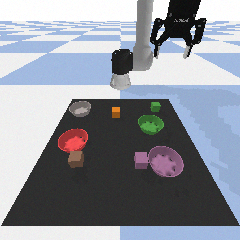

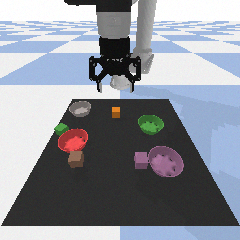

In [59]:
from PIL import Image
first_frame=rendered_clip.get_frame(0)
last_frame=rendered_clip.get_frame(rendered_clip.duration - (1.0 / rendered_clip.fps))
first_image = Image.fromarray(first_frame)
last_image = Image.fromarray(last_frame)
first_image.save('first_frame.png')
last_image.save('last_frame.png')
display(first_image,last_image)

In [60]:

for name in object_ids.keys():
    ids = object_ids[name]
    pos = pybullet.getBasePositionAndOrientation(ids)[0]
    visualShapeData = pybullet.getVisualShapeData(ids)
    print(name, pos[:2])

purple bottle (0.07051292037045499, -0.6309943104986495)
green bottle (-0.2528072232964133, -0.488654444717915)
brown bottle (-0.15293652204699412, -0.6267990535824166)
orange bottle (-0.023843435818199893, -0.3624533916715947)
green bowl (0.13618746995925904, -0.46141156554222107)
gray bowl (-0.210497909784317, -0.34172993898391724)
purple bowl (0.14982393980026246, -0.6452428698539734)
red bowl (-0.1846052199602127, -0.556186854839325)


In [61]:
import base64
def get_image_url(image_path):
    # 打开图片文件
    with open(image_path, "rb") as image_file:
        # 读取图片文件并转换为 Base64 编码字符串
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    # 构造 data URI 前缀
    data_uri = f"data:image/png;base64,{encoded_string}"
    return data_uri
table_coor='''
tabletop_coords = {
        'top_left':     (-0.3 + 0.05, -0.2 - 0.05),
        'top_side':     (0,           -0.2 - 0.05),
        'top_right':    (0.3 - 0.05,  -0.2 - 0.05),
        'left_side':    (-0.3 + 0.05, -0.5,      ),
        'middle':       (0,           -0.5,      ),
        'right_side':   (0.3 - 0.05,  -0.5,      ),
        'bottom_left':  (-0.3 + 0.05, -0.8 + 0.05),
        'bottom_side':  (0,           -0.8 + 0.05),
        'bottom_right': (0.3 - 0.05,  -0.8 + 0.05),
        'table_z':       0.0,
      }
'''

# from zhipuai import ZhipuAI
# client_zp = ZhipuAI(api_key='')

client=OpenAI(api_key='sk-KpMgNgTSYjOIgZH04aC062957dD747D88f147d9f986aC260' , base_url="https://one-api.glm.ai/v1")

def get_response_compare(user_input,command,coord1="",coord2="",img_url1="",img_url2=""):
    command_prompt=f'''
    You are helping the robot better understand human language.
    This is the user input need:{user_input}.
    The robot's operation is:{command}.
    Please judge if the robot's operation meets the human need.
    Answer Yes or No and explain why.
    '''
    response_command=client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content":[
                        {
                            "type":"text",
                            "text":command_prompt
                        }
                    ]
                }
            ],
            # model="glm-4v",
            model="gpt-4",
        ).choices[0].message.content
    compare_prompt=f'''
    You are helping the robot better understand human language. 
    This is the user input need:{user_input}.
    {coord1} are the coordinates of all the items before the operation.
    {coord2} are the coordinates of all the items after the operation.
    {table_coor} are the coordinates of the table.
    The blocks are bottles in the images.
    Please compare the coordinates to judge if the robot's operation meets the human need.
    Answer Yes or No and explain why.
    '''
    response_compare=client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content":[
                        {
                            "type":"text",
                            "text":compare_prompt
                        }
                        # {
                        #     "type":"image_url",
                        #     "image_url":{
                        #         "url":img_url1
                        #     }
                        # },
                        # {
                        #     "type":"image_url",
                        #     "image_url":
                        #     {
                        #         "url":img_url2
                        #     }
                        # }
                    ]
                }
            ],
            # model="glm-4v",
            model="gpt-4",
        ).choices[0].message.content

    return response_command,response_compare

img1=get_image_url("first_frame.png")
img2=get_image_url("last_frame.png")
coord1=str(obj_pos1)
coord2=str(obj_pos2)
response_command,response_compare=get_response_compare(user_input,command,coord1,coord2,img1,img2)
print(response_command)
print(response_compare)

No, the robot's operation doesn't meet the human's need. The user's statement reflects frustration or self-deprecation, not a command. While the robot is correct that no specific command was provided, it could ideally recognize the emotional context and respond in a more supportive or helpful manner, rather than just registering the absence of a command.
No, the robot's operation does not meet the human need. The user's statement "I am so stupid to use you.." is an expression of frustration or dissatisfaction, which implies that the robot is not performing to the user's satisfaction. The changes in the coordinates suggest minimal or no movement in the items, which implies that the robot has not made any significant changes in response to the user's feedback. There's no clear user request in the input but the dissatisfaction implys the user's needs are not currently met.
